( I tried running this, direct from the authors repo, the only needed change is to the data_path, and comment out the summary ... this too blew up while training, epoch 7 ... the same as my version of this. sigh.)

# Version 4 - Adding Augmentations, Batch Norm, Regularizers

## 1. Imports

In [1]:
import os

import numpy as np
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from PIL import Image
from IPython.display import display

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import StepLR
# from torchsummary import summary
from tqdm import tqdm

## 2. Setup data

In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [4]:
## set the path to train and test set
# data_path = ## drive location
## for colab set the folders in colab root folder

#!unzip <zip file location>
data_path = '/content/chest_xray'

data_path = '/tf/All/Data/Kaggle/Chest_X-ray_Images'

## 3. Explore data

In [5]:
class_name = ['NORMAL','PNEUMONIA']
def get_list_files(dirName):
    '''
    input - directory location
    output - list the files in the directory
    '''
    files_list = os.listdir(dirName)
    return files_list

files_list_normal_train = get_list_files(data_path+'/train/'+class_name[0])
files_list_pneu_train = get_list_files(data_path+'/train/'+class_name[1])

files_list_normal_test = get_list_files(data_path+'/test/'+class_name[0])
files_list_pneu_test = get_list_files(data_path+'/test/'+class_name[1])

In [6]:
print("Number of train samples in Normal category {}".format(len(files_list_normal_train)))
print("Number of train samples in Pneumonia category {}".format(len(files_list_pneu_train)))

print("Number of test samples in Normal category {}".format(len(files_list_normal_test)))
print("Number of test samples in Pneumonia category {}".format(len(files_list_pneu_test)))

Number of train samples in Normal category 1349
Number of train samples in Pneumonia category 3883
Number of test samples in Normal category 234
Number of test samples in Pneumonia category 390


(1542, 1600)


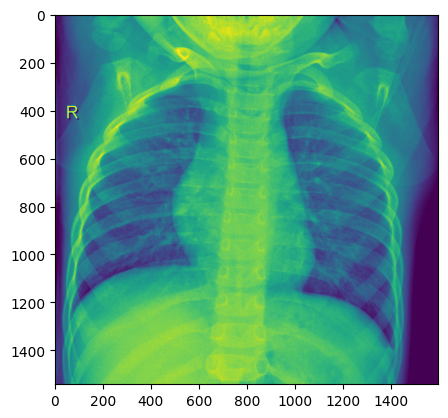

In [7]:
## get random file to check
img = data_path + '/train/NORMAL/'+ files_list_normal_train[np.random.randint(0,len(files_list_normal_train))]
print(plt.imread(img).shape)
#display(Image.open(img,'r'),)

img = mpimg.imread(img)
imgplot = plt.imshow(img)
plt.show()

(608, 1088)


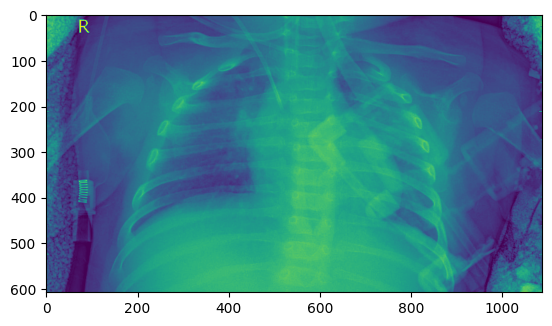

In [8]:
## get random file to check pneumona 
img = data_path + '/train/PNEUMONIA/'+ files_list_pneu_train[np.random.randint(0,len(files_list_pneu_train))]
print(plt.imread(img).shape)
#display(Image.open(img,'r'),)

img = mpimg.imread(img)
imgplot = plt.imshow(img)
plt.show()

In [9]:
train_transform = transforms.Compose([
    
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225])
])

In [10]:
## getting train and test data loader in place
train_data = datasets.ImageFolder(os.path.join(data_path, 'train'), transform= train_transform)
test_data = datasets.ImageFolder(os.path.join(data_path, 'test'), transform= test_transform)

train_loader = DataLoader(train_data,
                          batch_size= 16, shuffle= True, pin_memory= True)
test_loader = DataLoader(test_data, 
                         batch_size= 1, shuffle= False, pin_memory= True)

class_names = train_data.classes

print(class_names)
print(f'Number of train images: {len(train_data)}')
print(f'Number of test images: {len(test_data)}')

['NORMAL', 'PNEUMONIA']
Number of train images: 5232
Number of test images: 624


## 4. Define Model

In [11]:

import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3, 3), 
                      padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8)
        ) 
        self.pool11 = nn.MaxPool2d(2, 2)

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3),
                      padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        ) 

        self.pool22 = nn.MaxPool2d(2, 2) 


        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            
            nn.ReLU(),
            nn.BatchNorm2d(10),
        ) 
        self.pool33 = nn.MaxPool2d(2, 2) 
        

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10)
        )

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            
            nn.ReLU(),
            nn.BatchNorm2d(32),
           
        ) 


        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10),
            
        )

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10)
         
        )

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )


        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10)
            
        ) 

        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(14)
            
        ) 

        self.convblock11 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16)
            
        ) 
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) 

        self.convblockout = nn.Sequential(
              nn.Conv2d(in_channels=16, out_channels=2, kernel_size=(4, 4), padding=0, bias=False),

        ) 

    def forward(self, x):
        x = self.convblock1(x)
        x = self.pool11(x)
        x = self.convblock2(x)
        x = self.pool22(x)
        x = self.convblock3(x)
        x = self.pool33(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)
        x = self.convblock11(x)
        x = self.gap(x)        
        x = self.convblockout(x)

        x = x.view(-1, 2)
        return F.log_softmax(x, dim=-1)


In [12]:

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Available processor {}".format(device))
model = Net().to(device)
# summary(model, input_size=(3, 224, 224))

Available processor cuda


## 5. Training

In [13]:


train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

def train(model, device, train_loader, optimizer, epoch,l1=0,lambda1 = 10e-4):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, gradient is accumulated over backprop and even though thats used in RNN generally not used in CNN 
        # or specific requirements
        # Predict
        y_pred = model(data)

        # Calculate loss
        loss = F.nll_loss(y_pred, target)
        l1 = 0
        for p in model.parameters():
            l1=l1+p.abs().sum()
        loss = loss+lambda1*l1

        train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_accuracies.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  
            pred = output.argmax(dim=1, keepdim=True)  
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

    test_accuracies.append(100. * correct / len(test_loader.dataset))


In [14]:


model =  Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.5)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH number:", epoch)
    train(model, device, train_loader, optimizer, epoch,l1=0,lambda1 = 10e-4)
    scheduler.step()
    print('Current Learing Rate: ', optimizer.state_dict()["param_groups"][0]["lr"])
    test(model, device, test_loader)

EPOCH number: 0


Loss=0.5957797765731812 Batch_id=326 Accuracy=90.90: 100%|██████████| 327/327 [01:19<00:00,  4.12it/s]


Current Learing Rate:  0.01

Test set: Average loss: 0.5477, Accuracy: 489/624 (78.37%)

EPOCH number: 1


Loss=0.5261325240135193 Batch_id=326 Accuracy=93.60: 100%|██████████| 327/327 [01:09<00:00,  4.68it/s] 


Current Learing Rate:  0.01

Test set: Average loss: 0.5552, Accuracy: 502/624 (80.45%)

EPOCH number: 2


Loss=0.5789129137992859 Batch_id=326 Accuracy=94.00: 100%|██████████| 327/327 [01:12<00:00,  4.49it/s] 


Current Learing Rate:  0.01

Test set: Average loss: 1.0376, Accuracy: 461/624 (73.88%)

EPOCH number: 3


Loss=0.4511570334434509 Batch_id=326 Accuracy=94.04: 100%|██████████| 327/327 [01:09<00:00,  4.73it/s] 


Current Learing Rate:  0.01

Test set: Average loss: 0.9223, Accuracy: 445/624 (71.31%)

EPOCH number: 4


Loss=0.3936764597892761 Batch_id=326 Accuracy=94.65: 100%|██████████| 327/327 [01:10<00:00,  4.62it/s] 


Current Learing Rate:  0.01

Test set: Average loss: 0.4866, Accuracy: 507/624 (81.25%)

EPOCH number: 5


Loss=0.43694543838500977 Batch_id=326 Accuracy=94.25: 100%|██████████| 327/327 [01:12<00:00,  4.51it/s]


Current Learing Rate:  0.005

Test set: Average loss: 0.7999, Accuracy: 454/624 (72.76%)

EPOCH number: 6


Loss=0.5211634635925293 Batch_id=326 Accuracy=95.26: 100%|██████████| 327/327 [01:19<00:00,  4.12it/s] 


Current Learing Rate:  0.005

Test set: Average loss: 0.7960, Accuracy: 472/624 (75.64%)

EPOCH number: 7


Loss=0.3115648031234741 Batch_id=285 Accuracy=95.06:  87%|████████▋ | 286/327 [01:36<02:38,  3.87s/it] 

: 

Text(0.5, 1.0, 'Test Accuracy')

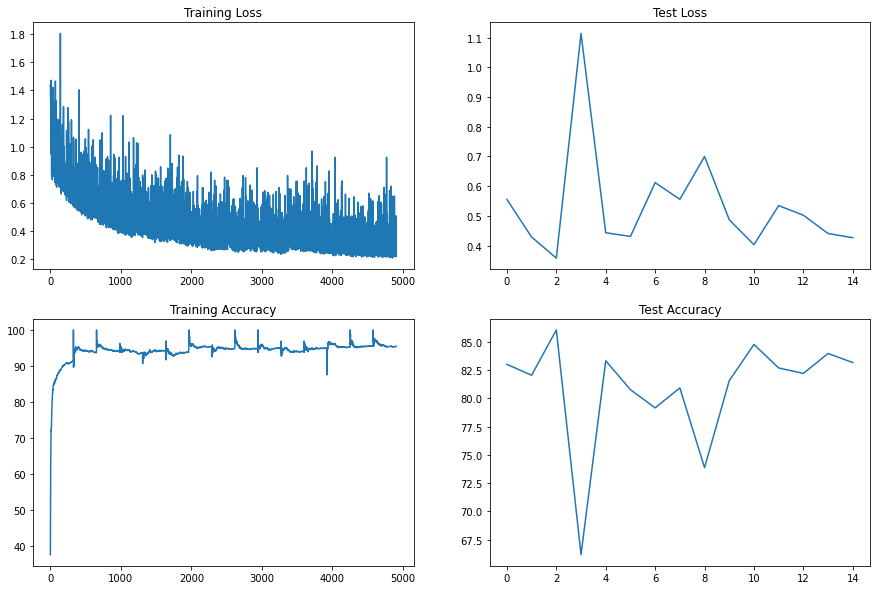

In [ ]:

torch.cuda.synchronize()
train_losses1 = [float(i.cpu().detach().numpy()) for i in train_losses]
train_acc1 = [i for i in train_accuracies]
test_losses1 = [i for i in test_losses]
test_acc1 = [i for i in test_accuracies]

fig, axs = plt.subplots(2,2,figsize=(16,10))
axs[0, 0].plot(train_losses1,color='green')
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc1,color='green')
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses1)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc1)
axs[1, 1].set_title("Test Accuracy")